Sınıf sayısı: 10 farklı hayvan (kedi, köpek, at, inek, kuş, tavşan, fare, fil, ayı, kaplumbağa).

Görsel sayısı: Toplam yaklaşık 14.000 resim, her sınıfın görsel sayısı birbirine yakın (dengeli).

Klasör yapısı: Her sınıfın kendi klasörü var, içinde .jpeg dosyaları.

Train/Validation/Test: Ayrı bir bölünme yok, yani train/val/test ayırma işlemini bizim yapmamız gerekiyor.

Boyut ve format: Renkli JPEG görseller, boyutları değişken, CNN için uygun.

Özetle, bu veri seti orta büyüklükte bir sınıflandırma veri seti ve CNN eğitimi için hazır,yapmamız gereken:

Görüntüleri yeniden boyutlandırmak (ör. 128x128).

Train/Validation/Test setlerini ayırmak.

CNN modeli kurmak ve eğitmek.

Öncelikle gerekli kütüphaneleri import edelim.

In [1]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-25 19:52:34.552167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758829954.923293      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758829955.024992      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/animals10/raw-img"          # Orijinal veri seti
base_dir = "Animals-10-split"    # Train/val/test klasörleri için yeni temel klasör

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

img_height, img_width = 128, 128
batch_size = 32
num_classes = 10


train val test klasörlerini oluşturalım

In [3]:
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)
        
print("klasörler oluşturuldu")

klasörler oluşturuldu


# Veriyi %80 train, %10 validation, %10 test olarak ayırıyoruz
# Her sınıf için klasörler oluşturuluyor ve dosyalar ilgili klasörlere kopyalanıyor


In [4]:
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    images = os.listdir(class_path)
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val  # kalan test

    train_images = images[:n_train]
    val_images = images[n_train:n_train+n_val]
    test_images = images[n_train+n_val:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'val', class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'test', class_name, img))

print("split işlemi tamamlandı")

split işlemi tamamlandı


# ImageDataGenerator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 128, 128
batch_size = 32

# Train generator (data augmentation uygulanıyor)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation ve Test generator (sadece rescale)
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'Animals-10-split/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    'Animals-10-split/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    'Animals-10-split/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 20938 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.


CNN modeli


In [6]:
from tensorflow.keras import layers, models

num_classes = 10  # 10 farklı hayvan sınıfı var.

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758830596.041939      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758830596.042686      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Callback'ler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Eğitim
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1758830618.722853     119 service.cc:148] XLA service 0x79d670006240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758830618.724478     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758830618.724524     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758830619.140937     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/655 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.1146 - loss: 2.6011  

I0000 00:00:1758830623.365163     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


655/655 ━━━━━━━━━━━━━━━━━━━━ 107s 152ms/step - accuracy: 0.2181 - loss: 2.1781 - val_accuracy: 0.3359 - val_loss: 1.9073 - learning_rate: 0.0010
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.3271 - loss: 1.9084 - val_accuracy: 0.4396 - val_loss: 1.6610 - learning_rate: 0.0010
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.3965 - loss: 1.7435 - val_accuracy: 0.5111 - val_loss: 1.4629 - learning_rate: 0.0010
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4426 - loss: 1.6239 - val_accuracy: 0.5325 - val_loss: 1.3557 - learning_rate: 0.0010
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.4760 - loss: 1.5322 - val_accuracy: 0.5302 - val_loss: 1.3577 - learning_rate: 0.0010
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.5074 - loss: 1.4503 - val_accuracy: 0.5126 - val_loss: 1.3633 - learning_rate: 0.0010
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.5168 - loss

## Model Değerlendirmesi 

Epoch bazında accuracy-loss grafikleri

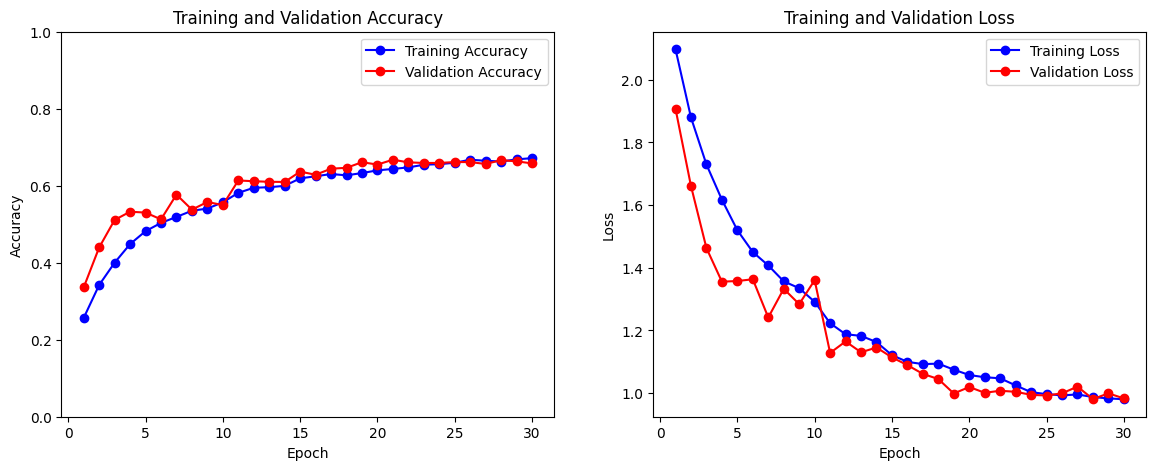

In [15]:
import matplotlib.pyplot as plt

# Eğitim sürecinden history objesi kaydedilmişti.Bu obje üzerinden işlemler yapılacak.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,5))

# Accuracy grafiği
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

- Model stabil öğrenmiş. Traning ve validation eğrileri birbirine yakın. Overfitting gözükmüyor.
- Şu anda ~%68 civarı doğruluk alınıyor. Daha yüksek performans için ilerleyen aşamalarda trasnfer learning uygulanacak.

Confussion matrix ve classification report

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


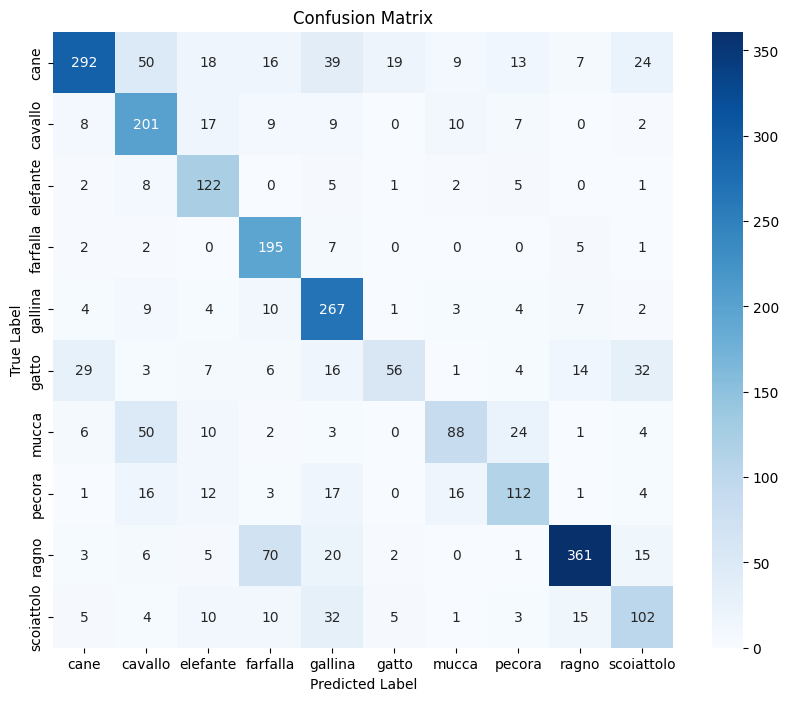

Classification Report:

              precision    recall  f1-score   support

        cane       0.83      0.60      0.70       487
     cavallo       0.58      0.76      0.66       263
    elefante       0.60      0.84      0.70       146
    farfalla       0.61      0.92      0.73       212
     gallina       0.64      0.86      0.74       311
       gatto       0.67      0.33      0.44       168
       mucca       0.68      0.47      0.55       188
      pecora       0.65      0.62      0.63       182
       ragno       0.88      0.75      0.81       483
  scoiattolo       0.55      0.55      0.55       187

    accuracy                           0.68      2627
   macro avg       0.67      0.67      0.65      2627
weighted avg       0.71      0.68      0.68      2627



In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test seti tahminleri
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


Heatmap görselleştirme(Grad-CAM ile) modelin hangi bölgelere yoğunlaştığını gözlemleyelim. Bu kısımda ChatGPT'den büyük yardım aldım, bilgim dahilinde olan bir konu değildi.

In [41]:
# GUARANTEED WORKING HEATMAP - GEREKLİ PAKETLER
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_heatmap_simple(model, img_path=None, test_generator=None, img_index=0):
    """
    Kesinlikle çalışan basit heatmap yöntemi
    Model.input kullanmaz, gradient problemi yok
    
    Kullanım:
    - create_heatmap_simple(model, img_path="path/to/image.jpg")  # Direkt path
    - create_heatmap_simple(model, test_generator=test_gen, img_index=0)  # Generator'dan
    """
    
    # Görsel path'ini belirle
    if img_path is not None:
        print(f" Heatmap oluşturuluyor - Direkt path: {img_path}")
        # Path kontrolü
        import os
        if not os.path.exists(img_path):
            print(f" Dosya bulunamadı: {img_path}")
            return False
    elif test_generator is not None:
        img_path = test_generator.filepaths[img_index]
        print(f" Heatmap oluşturuluyor - Generator görsel {img_index}")
    else:
        print(" Hata: img_path veya test_generator belirtilmeli!")
        return False
    
    print(f" Dosya: {img_path}")
    
    # 1. Görsel hazırla
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # 2. Tahmin yap
    predictions = model.predict(img_array, verbose=0)
    pred_class = np.argmax(predictions[0])
    confidence = predictions[0][pred_class]
    
    print(f" Tahmin: Sınıf {pred_class}, Güven: {confidence:.3f}")
    
    # 3. ACTIVATION-BASED HEATMAP (en güvenli yöntem)
    try:
        # Son conv katmanını bul
        conv_layer_name = None
        for layer in reversed(model.layers):
            if 'conv' in layer.name:
                conv_layer_name = layer.name
                break
        
        print(f" Kullanılan katman: {conv_layer_name}")
        
        # Katmana kadar modeli çalıştır
        x = img_array
        for i, layer in enumerate(model.layers):
            x = layer(x)
            if layer.name == conv_layer_name:
                activations = x
                break
        
        # Activations: (batch, height, width, channels)
        print(f"🔧 Activation shape: {activations.shape}")
        
        # YÖNTEM 1: Channel-wise average (en basit)
        heatmap_avg = tf.reduce_mean(activations[0], axis=-1)
        heatmap_avg = tf.nn.relu(heatmap_avg)  # Pozitif değerler
        heatmap_avg = heatmap_avg / tf.reduce_max(heatmap_avg)
        
        # YÖNTEM 2: Max activation (en yoğun özellikler)
        heatmap_max = tf.reduce_max(activations[0], axis=-1)
        heatmap_max = heatmap_max / tf.reduce_max(heatmap_max)
        
        # YÖNTEM 3: Weighted average (tahmine göre ağırlıklı)
        # Her channel için ağırlık hesapla
        channel_weights = []
        for channel in range(activations.shape[-1]):
            single_channel = activations[0, :, :, channel:channel+1]
            # Bu channelı sıfırlayıp tahmin farkına bak
            modified_activations = activations.numpy()
            modified_activations[0, :, :, channel] = 0
            
            # Basit ağırlık hesaplaması
            weight = tf.reduce_mean(single_channel).numpy()
            channel_weights.append(weight)
        
        # Ağırlıklı kombinasyon
        channel_weights = np.array(channel_weights)
        channel_weights = channel_weights / np.sum(channel_weights)
        
        heatmap_weighted = np.zeros(activations.shape[1:3])
        for i, weight in enumerate(channel_weights):
            heatmap_weighted += weight * activations[0, :, :, i].numpy()
        
        heatmap_weighted = np.maximum(heatmap_weighted, 0)
        heatmap_weighted = heatmap_weighted / np.max(heatmap_weighted)
        
        print(" Üç farklı heatmap yöntemi başarılı!")
        
        # 4. Görselleştirme
        original = cv2.imread(img_path)
        original = cv2.resize(original, (128, 128))
        
        # 2x3 subplot
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Üst sıra: Ham heatmapler
        heatmaps = [heatmap_avg.numpy(), heatmap_max.numpy(), heatmap_weighted]
        titles = ['Average Activation', 'Max Activation', 'Weighted Activation']
        
        for i, (heatmap, title) in enumerate(zip(heatmaps, titles)):
            axes[0, i].imshow(heatmap, cmap='jet')
            axes[0, i].set_title(f'{title}\nHeatmap')
            axes[0, i].axis('off')
        
        # Alt sıra: Overlay'ler
        for i, (heatmap, title) in enumerate(zip(heatmaps, titles)):
            # Heatmap'i resize et ve colorize et
            heatmap_resized = cv2.resize(heatmap, (128, 128))
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            
            # Overlay oluştur
            overlay = cv2.addWeighted(original, 0.6, heatmap_colored, 0.4, 0)
            overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
            
            axes[1, i].imshow(overlay_rgb)
            axes[1, i].set_title(f'{title}\nOverlay')
            axes[1, i].axis('off')
        
        plt.suptitle(f' HEATMAP ANALİZİ\nTahmin: Sınıf {pred_class} (Güven: {confidence:.3f})\nGörsel: {img_path.split("/")[-1]}', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        print(" HEATMAP BAŞARILI! Modelinizin hangi bölgelere odaklandığını görebilirsiniz.")
        
        return True
        
    except Exception as e:
        print(f" Heatmap hatası: {e}")
        
        # YEDEK PLAN: Occlusion-based saliency
        print(" Alternatif yöntem deneniyor: Occlusion Saliency")
        
        try:
            # Basit occlusion saliency
            height, width = 128, 128
            window_size = 16
            stride = 8
            
            saliency_map = np.zeros((height, width))
            
            # Orijinal skor
            original_score = predictions[0][pred_class]
            
            print(" Occlusion analizi (biraz bekleyin)...")
            
            for y in range(0, height - window_size, stride):
                for x in range(0, width - window_size, stride):
                    # Bölgeyi siyah yap
                    modified_img = img_array.copy()
                    modified_img[0, y:y+window_size, x:x+window_size, :] = 0
                    
                    # Yeni tahmin
                    new_pred = model.predict(modified_img, verbose=0)
                    new_score = new_pred[0][pred_class]
                    
                    # Önem skoru
                    importance = original_score - new_score
                    saliency_map[y:y+window_size, x:x+window_size] += importance
            
            # Normalize
            saliency_map = np.maximum(saliency_map, 0)
            if saliency_map.max() > 0:
                saliency_map = saliency_map / saliency_map.max()
            
            # Görselleştir
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
            plt.title("Orijinal Görsel")
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(saliency_map, cmap='jet')
            plt.title("Occlusion Saliency")
            plt.axis('off')
            
            # Overlay
            saliency_colored = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(original, 0.6, saliency_colored, 0.4, 0)
            
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title("Saliency Overlay")
            plt.axis('off')
            
            plt.suptitle(f'Occlusion-Based Heatmap\nTahmin: Sınıf {pred_class} (Güven: {confidence:.3f})')
            plt.tight_layout()
            plt.show()
            
            print(" Occlusion-based heatmap başarılı!")
            return True
            
        except Exception as e2:
            print(f" Tüm yöntemler başarısız: {e2}")
            return False

# Çoklu görsel analizi - UPDATED
def multiple_heatmaps(model, test_generator=None, img_paths=None, num_images=3):
    """
    Birden fazla görsel için heatmap
    
    Kullanım:
    - multiple_heatmaps(model, img_paths=["path1.jpg", "path2.jpg", "path3.jpg"])
    - multiple_heatmaps(model, test_generator=test_gen, num_images=3)
    """
    
    if img_paths is not None:
        # Direkt path listesi kullan
        print(f" {len(img_paths)} görsel için heatmap oluşturuluyor (direkt path)...")
        
        for i, img_path in enumerate(img_paths):
            print(f"\n{'='*50}")
            print(f" Görsel {i+1}/{len(img_paths)}")
            print(f"{'='*50}")
            
            success = create_heatmap_simple(model, img_path=img_path)
            
            if not success:
                print(f" Görsel {i+1} için heatmap oluşturulamadı")
    
    elif test_generator is not None:
        # Generator kullan
        print(f" {num_images} görsel için heatmap oluşturuluyor (generator)...")
        
        for i in range(num_images):
            print(f"\n{'='*50}")
            print(f" Görsel {i+1}/{num_images}")
            print(f"{'='*50}")
            
            success = create_heatmap_simple(model, test_generator=test_generator, img_index=i)
            
            if not success:
                print(f" Görsel {i+1} için heatmap oluşturulamadı")
    
    else:
        print(" Hata: img_paths veya test_generator belirtilmeli!")
        return False
    
    print("\n Çoklu heatmap analizi tamamlandı!")

# YENİ: Tek seferlik tahmin fonksiyonu
def predict_single_image(model, img_path):
    """Tek bir görsel için hızlı tahmin"""
    
    print(f" Tahmin yapılıyor: {img_path}")
    
    try:
        # Görsel yükle
        img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Tahmin yap
        predictions = model.predict(img_array, verbose=0)
        pred_class = np.argmax(predictions[0])
        confidence = predictions[0][pred_class]
        
        print(f"📊 Sonuç: Sınıf {pred_class}, Güven: {confidence:.3f}")
        
        # Basit görselleştirme
        original = cv2.imread(img_path)
        original = cv2.resize(original, (128, 128))
        
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title(f"Tahmin: Sınıf {pred_class}\nGüven: {confidence:.3f}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.bar(range(len(predictions[0])), predictions[0])
        plt.title("Sınıf Olasılıkları")
        plt.xlabel("Sınıf")
        plt.ylabel("Olasılık")
        
        plt.tight_layout()
        plt.show()
        
        return pred_class, confidence
        
    except Exception as e:
        print(f" Hata: {e}")
        return None, None

print(" UPDATED HEATMAP ÇÖZÜMÜ HAZIR!")
print("\n YENİ KULLANIM ÖRNEKLERİ:")
print("\n1️ Direkt path ile heatmap:")
print('   create_heatmap_simple(model, img_path="Animals-10-split/test/cane/OIP-xyz.jpeg")')
print("\n2️ Çoklu direkt path:")
print('   paths = ["image1.jpg", "image2.jpg", "image3.jpg"]')
print('   multiple_heatmaps(model, img_paths=paths)')
print("\n3️ Hızlı tahmin:")
print('   predict_single_image(model, "your_image.jpg")')
print("\n4️  Eski yöntem (generator):")
print('   create_heatmap_simple(model, test_generator=test_generator, img_index=0)')

 UPDATED HEATMAP ÇÖZÜMÜ HAZIR!

 YENİ KULLANIM ÖRNEKLERİ:

1️ Direkt path ile heatmap:
   create_heatmap_simple(model, img_path="Animals-10-split/test/cane/OIP-xyz.jpeg")

2️ Çoklu direkt path:
   paths = ["image1.jpg", "image2.jpg", "image3.jpg"]
   multiple_heatmaps(model, img_paths=paths)

3️ Hızlı tahmin:
   predict_single_image(model, "your_image.jpg")

4️  Eski yöntem (generator):
   create_heatmap_simple(model, test_generator=test_generator, img_index=0)


 Heatmap oluşturuluyor - Direkt path: /kaggle/working/Animals-10-split/test/farfalla/OIP--Mpfd_ozZWI-BuFQkizVrwHaFj.jpeg
 Dosya: /kaggle/working/Animals-10-split/test/farfalla/OIP--Mpfd_ozZWI-BuFQkizVrwHaFj.jpeg
 Tahmin: Sınıf 3, Güven: 0.860
 Kullanılan katman: conv2d_2
🔧 Activation shape: (1, 28, 28, 128)
 Üç farklı heatmap yöntemi başarılı!


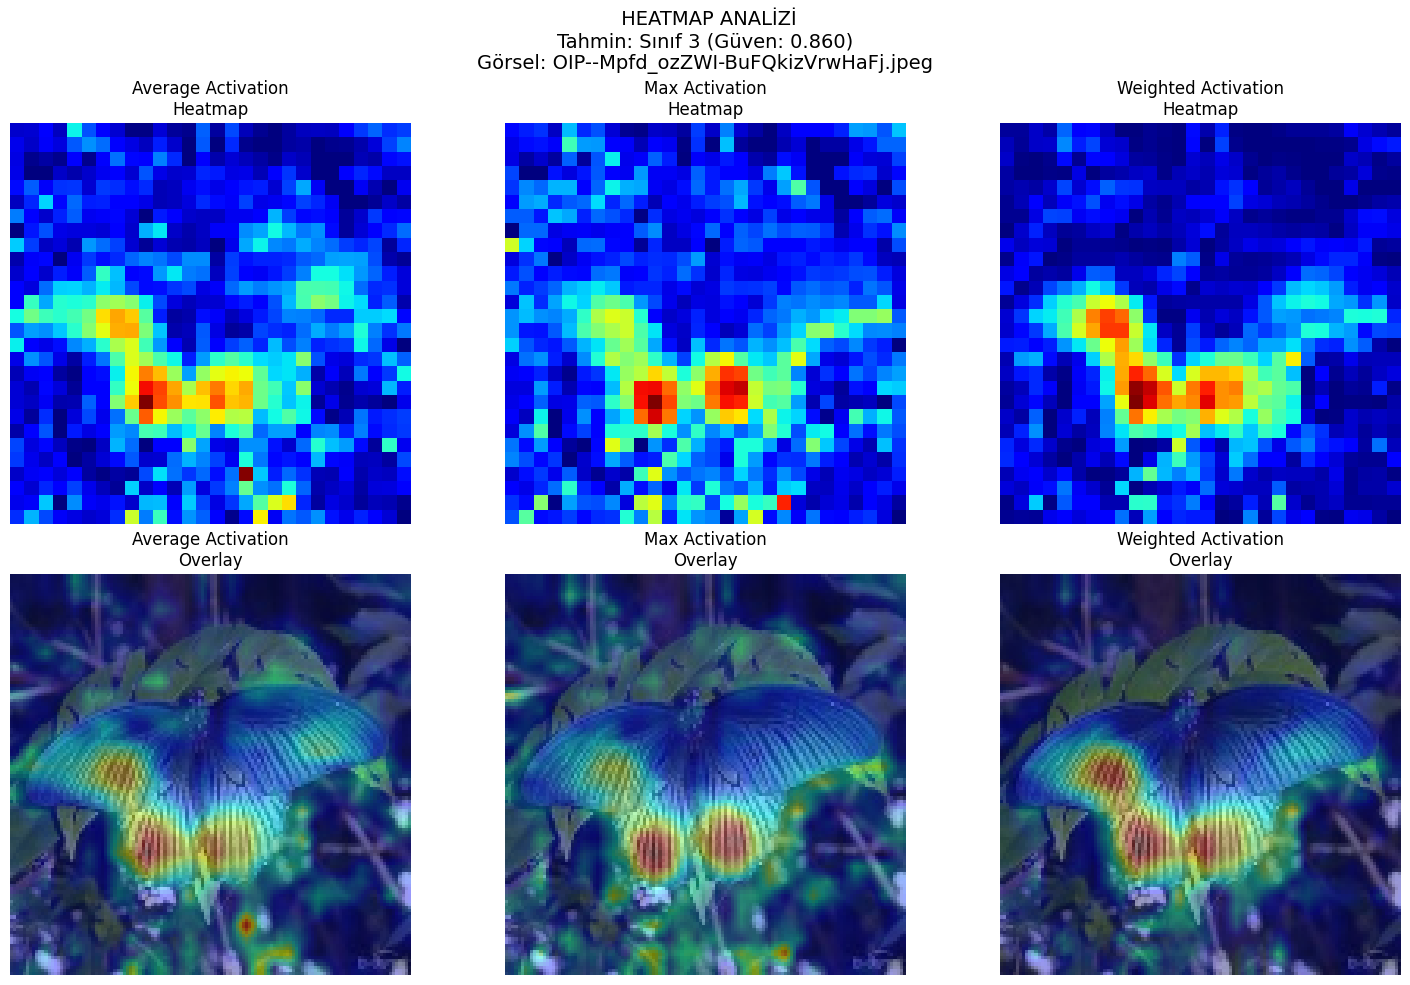

 HEATMAP BAŞARILI! Modelinizin hangi bölgelere odaklandığını görebilirsiniz.


True

In [46]:
   create_heatmap_simple(model, img_path="/kaggle/working/Animals-10-split/test/farfalla/OIP--Mpfd_ozZWI-BuFQkizVrwHaFj.jpeg")